In [1]:
import random
import numpy as np
import igraph as ig

In [2]:
def Creation(n):
    
    g = ig.Graph.Lattice(dim=[n,n], circular=False)

    N = len(g.vs)
    m = random.randrange(0,N)
    n = N-m
    a = np.ones(N)
    a[:m] = 0
    np.random.shuffle(a)
    A = np.array(np.reshape(a,(len(a),1)))

    g.vs["original_id"] = list(range(g.vcount()))
    g.vs["spin"] = list(a)
    
    return g

In [3]:
def Plot_IGraph(g):

    visual_style = {}
    visual_style["vertex_size"] = 10
    visual_style["bbox"] = (300, 300)
    #visual_style["vertex_label"] = g.vs["original_id"]
    color_dict = {1.0: "grey", 0.0 : "white"}
    visual_style["vertex_color"] = [color_dict[gender] for gender in g.vs["spin"]]
    ##############################################################################
    edge_colors = []
    for edge in g.get_edgelist():

        a = g.vs[edge[0]]["spin"]
        b = g.vs[edge[1]]["spin"]

        if a == b:

            if a == b == 1.0:
                    edge_colors.append("red")
            if a == b == 0.0:
                    edge_colors.append("green")

        else:
            edge_colors.append("lightgrey")
    ##############################################################################
    visual_style["edge_color"] = edge_colors
    
    return visual_style

In [4]:
def frustration_count(g):
    s = 0
    for edge in g.get_edgelist():
        a = g.vs[edge[0]]["spin"]
        b = g.vs[edge[1]]["spin"]
        if a == b:
            s+=1
    return s

def color_of_frustration(g):
    p=0
    n=0        
    for edge in g.get_edgelist():
        a = g.vs[edge[0]]["spin"]
        b = g.vs[edge[1]]["spin"]
        if a == b or b == a:
            if a == b == 1.0:
                n +=1
            if b == a == 0.0:
                p +=1       
    return p,n

def calculate_delta(g):
    p,n = color_of_frustration(g)
    if p>n:
        return int(np.sqrt((p-n)**2))
    else:
        return int(np.sqrt((n-p)**2))

220
120 36
42 78


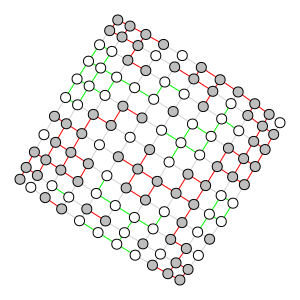

In [5]:
g = Creation(11)

f = frustration_count(g)
d = calculate_delta(g)
p,n = color_of_frustration(g)

print(g.ecount())
print(f,d)
print(p,n)

visual_style = Plot_IGraph(g)
ig.plot(g, **visual_style)

# Rewiring

In [6]:
# https://networkx.org/documentation/stable/_modules/networkx/algorithms/swap.html#connected_double_edge_swap
from networkx.utils import py_random_state

import networkx as nx

@py_random_state(3)

def connected_double_edge_swap(g, nswap=1, _window_threshold=3, seed=None):

    n = 0
    swapcount = 0

    deg = g.degree()

    dk = [v.index for v in g.vs]
    cdf = nx.utils.cumulative_distribution(g.degree())
    discrete_sequence = nx.utils.discrete_sequence
    window = 1

    while n < nswap:
        wcount = 0
        swapped = []
        if window < _window_threshold:
            fail = False
            while wcount < window and n < nswap:
                (ui, xi) = discrete_sequence(2, cdistribution=cdf, seed=seed)
                if ui == xi:
                    continue
                u = dk[ui]
                x = dk[xi]
                v = seed.choice(list(g.neighbors(u)))
                y = seed.choice(list(g.neighbors(x)))
                if v == y:
                    continue
                if x not in g.neighbors(u) and y not in g.neighbors(v):
                    g.delete_edges([(u, v)])
                    g.delete_edges([(x, y)])
                    g.add_edge(u, x)
                    g.add_edge(v, y)
                    swapped.append((u, v, x, y))
                    swapcount += 1
                n += 1
                #https://stackoverflow.com/questions/13855617/check-if-two-vertices-are-connected-in-igraph
                #print("has_path",u,v,g.get_eid(u, v, directed=False, error=False))
                #print(g.get_shortest_paths(u,to=v))
                if len(g.get_shortest_paths(u,to=v)) != 0:
                    #print("has path")#,g.get_eid(u, v, directed=False, error=False))
                    wcount += 1
                else:
                    g.add_edge(u, v)
                    g.add_edge(x, y)
                    g.delete_edges([(u, x)])
                    g.delete_edges([(v, y)])
                    swapcount -= 1
                    fail = True
            if fail:
                window = int(math.ceil(window / 2))
            else:
                window += 1

        else:
            while wcount < window and n < nswap:
                (ui, xi) = nx.utils.discrete_sequence(2, cdistribution=cdf)
                if ui == xi:
                    continue
                u = dk[ui]
                x = dk[xi]
                v = seed.choice(list(g.neighbors(u)))
                y = seed.choice(list(g.neighbors(x)))
                if v == y:
                    continue
                if x not in g.neighbors(u) and y not in g.neighbors(v):
                    g.delete_edges([(u, v)])
                    g.delete_edges([(x, y)])
                    g.add_edge(u, x)
                    g.add_edge(v, y)
                    swapped.append((u, v, x, y))
                    swapcount += 1
                n += 1
                wcount += 1
            #print(g.is_connected())
            if g.is_connected():
                window += 1
            else:
                while swapped:
                    (u, v, x, y) = swapped.pop()
                    g.add_edge(u, v)
                    g.add_edge(x, y)
                    g.delete_edges([(u, x)])
                    g.delete_edges([(v, y)])
                    swapcount -= 1
                window = int(math.ceil(window / 2))
    return swapcount

220
155 127
141 14


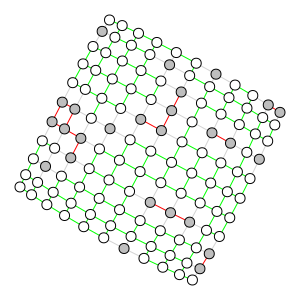

In [10]:
g = Creation(11)

f = frustration_count(g)
d = calculate_delta(g)
p,n = color_of_frustration(g)

print(g.ecount())
print(f,d)
print(p,n)

visual_style = Plot_IGraph(g)
ig.plot(g, **visual_style)

220
141 14


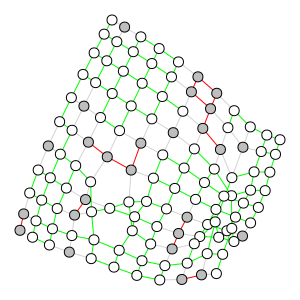

In [12]:
connected_double_edge_swap(g)

f = frustration_count(g)
d = calculate_delta(g)
p,n = color_of_frustration(g)

print(g.ecount())
print(p,n)

visual_style = Plot_IGraph(g)
ig.plot(g, **visual_style)

# Quench

In [13]:
N = 11

g0 = Creation(N)

edge_number = g0.ecount()
print(edge_number)

220


In [14]:
from tqdm import tqdm
import time

gs = []
start_time = time.time()
for i in tqdm(range(1000)):
    
    gi = Creation(11)
    
    di = calculate_delta(gi)
    fi = frustration_count(gi)
        
    if di != fi:
        gs.append(gi)

print(time.time() - start_time) 

100%|██████████| 1000/1000 [00:00<00:00, 2138.79it/s]

0.47001218795776367


In [15]:
from collections import Counter

avg = []
for g in tqdm(gs):
    
    f = frustration_count(g)
    d = calculate_delta(g)
    
    avg.append((f,d))
    
AVG = Counter(avg)

print(AVG)

100%|██████████| 882/882 [00:00<00:00, 2582.87it/s]

Counter({(192, 190): 7, (183, 179): 5, (166, 158): 4, (204, 202): 4, (169, 165): 4, (155, 143): 4, (191, 185): 4, (106, 2): 4, (126, 84): 3, (171, 167): 3, (112, 40): 3, (163, 153): 3, (146, 120): 3, (138, 110): 3, (175, 165): 3, (177, 173): 3, (135, 101): 3, (115, 63): 3, (203, 201): 3, (148, 132): 3, (160, 148): 3, (185, 181): 3, (177, 175): 3, (123, 81): 3, (106, 42): 3, (177, 171): 3, (108, 4): 3, (167, 165): 3, (161, 147): 3, (169, 157): 3, (176, 174): 3, (145, 127): 3, (148, 128): 3, (141, 121): 3, (172, 166): 3, (108, 34): 3, (109, 43): 2, (102, 16): 2, (139, 121): 2, (113, 53): 2, (111, 5): 2, (169, 163): 2, (178, 176): 2, (133, 97): 2, (136, 122): 2, (115, 11): 2, (168, 162): 2, (134, 114): 2, (167, 163): 2, (106, 12): 2, (122, 40): 2, (109, 3): 2, (138, 106): 2, (126, 64): 2, (159, 149): 2, (106, 6): 2, (120, 56): 2, (195, 193): 2, (104, 12): 2, (143, 133): 2, (162, 150): 2, (114, 68): 2, (136, 106): 2, (149, 139): 2, (117, 9): 2, (210, 208): 2, (108, 32): 2, (117, 49): 2, (2

In [26]:
selected_gs = []
for g in tqdm(gs):
    if (frustration_count(g),calculate_delta(g)) == (25, 21):
        selected_gs.append(g)
        if len(selected_gs) == 10:
            break

 74%|███████▍  | 519/703 [00:00<00:00, 13066.68it/s]


In [18]:
def Quench(gs,timesteps = 100):
    total=[]
    for index,g0 in tqdm(enumerate(gs)):
        specific_avg = []
        for i in range(timesteps):
            res=[]
            res.append(frustration_count(g0))
            G = g0.copy()
            for k in (range(1,timesteps)):
                connected_double_edge_swap(G)
                res.append(frustration_count(G))
            specific_avg.append(res)
        total.append(specific_avg) 
    return np.array(total)

In [38]:
timesteps = 100

data = Quench(selected_gs,timesteps)

0it [00:00, ?it/s]<ipython-input-8-d102e5756440>:46: RuntimeWarning: Couldn't reach some vertices at src/paths/unweighted.c:368
  if len(g.get_shortest_paths(u,to=v)) != 0:
10it [12:33, 75.39s/it]


In [16]:
def Get_Probabilites2(data,Edge,repeat):
    
    avg_P_t = []
    for a in data:
        p_t=[]
        for t in range(len(a[0])):

            prob=[]
            for i in range(0,Edge):
                prob.append(np.count_nonzero(np.array(a[:,t]) == i))
            p_t.append(np.array(prob)/repeat)

        P_t = np.array(p_t)
        avg_P_t.append(P_t)

    return np.array(avg_P_t)

In [17]:
edge_number = 220

avg_P_t = Get_Probabilites2(data,edge_number,timesteps)

print(np.shape(avg_P_t))

#avg_P_t[:,5]

avg_P = []
for t in range(timesteps):
    avg_p = []
    for i in range(edge_number):
        #print(i)
        #print(avg_P_t[:,t,i],np.mean(avg_P_t[:,t,i]),np.std(avg_P_t[:,t,i]))
        avg_p.append((np.mean(avg_P_t[:,t,i]),np.std(avg_P_t[:,t,i])))
    avg_P.append(avg_p)
    #break
    #print(avg_P_t[i,5])
    #avg_p.append(np.mean(avg_P_t[:,5][0]))
    
p_even=[]
for l in avg_P:
    p_even.append(l[1::2])

P_even = np.array(p_even)

NameError: name 'data' is not defined

In [31]:
import os

f = open("/home/sven/Desktop/pl40d21.txt",'r')


p_true=[]
for line in f:
    
    if len(line.rstrip("\n"))==1:
            p_true.append(0)
    else:
        p_true.append(float((line.rstrip("\n")).replace("*^","e")))#.replace("`50.","")))
        
p_true = np.array(p_true)
p_true = np.delete(p_true, -1)


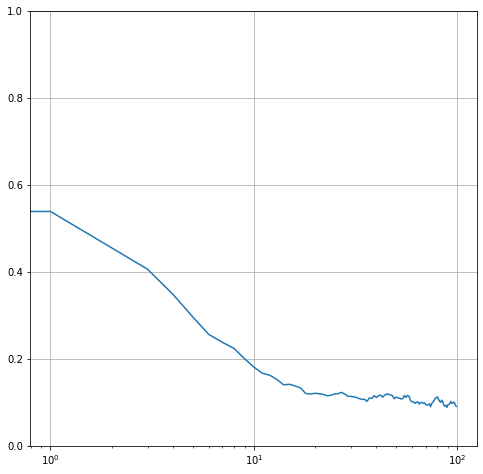

In [34]:
from scipy.spatial.distance import jensenshannon

import matplotlib.pyplot as plt
%matplotlib inline


JS = []

P = np.array(p_true)[1::2]
#print(np.round(P[P!=0],2))
    
for i in range(len(avg_P)):
    
    p = np.array(p_true)[1::2]
    q = np.array([k for k,j in avg_P[i]])[1::2]
    
    #print(q[q!=0])
    
    #print(p,q)
    
    js_pq1 = jensenshannon(p,q,base=2)
    #print(js_pq1)
    JS.append(js_pq1)
    #print('JS(Q || P) Distance: %.3f' % js_pq1,JS[i])
    
fig,ax = plt.subplots(figsize=[8,8])

ax.plot([i for i in range(len(JS))],JS)
ax.grid()
ax.set_ylim(0,1)
ax.set_xscale('log')
plt.show()

In [121]:
import random
import matplotlib
import tkinter as Tk
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from matplotlib.widgets import TextBox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

matplotlib.use('TkAgg')

root = Tk.Tk()
root.wm_title("Embedding in TK")
fig = plt.Figure(figsize=(15,15))
canvas = FigureCanvasTkAgg(fig, root)
canvas.get_tk_widget().pack(side=Tk.TOP, fill=Tk.BOTH, expand=1)


###############################################

ax=fig.add_subplot(111)
fig.subplots_adjust(bottom=0.25)

#fig.suptitle('L='+str(l)+', d='+str(k), fontsize=16)

t=0

x = [i for i in range(len(avg_P[t]))]
y = np.array([i for i,j in avg_P[t]])
y_err = np.array([j for i,j in avg_P[t]])

ax.errorbar(x,y,y_err,capsize=3)
l12  = ax.fill_between(x, y - y_err, y + y_err,facecolor="blue",alpha=0.2)#, alpha=0.25)#, edgecolor="black")


x = [i*2+1 for i in range(len(P_even[t]))]
y = np.array([i for i,j in P_even[t]])
y_err = np.array([j for i,j in P_even[t]])

ax.errorbar(x,y,y_err,capsize=3)
l12  = ax.fill_between(x, y - y_err, y + y_err,facecolor="red",alpha=0.2)#, alpha=0.25)#, edgecolor="black")


#ax.plot([i for i in range(len(p30_13))],p30_13,color="red")
ax.plot([i*2+1 for i in range(len(p_true[::2]))], p_true[::2],color="red")
ax.scatter([i*2+1 for i in range(len(p_true[::2]))], p_true[::2],color="red")


ax.set_ylim(0,1)
#ax.set_xlim(2650,2750)
ax.set_xlabel("f")
ax.set_ylabel("P(f)")
ax.grid()

###############################################
ax_time = fig.add_axes([0.12, 0.1, 0.78, 0.03])
s_time = Slider(ax_time, 'Time', 0, 99, valinit=0)

tekstić = ax.text(0.05, 0.95, s_time.val, transform=ax.transAxes, fontsize=14,
        verticalalignment='top')
###############################################



from mpl_toolkits.axes_grid.inset_locator import inset_axes

# this is an inset axes over the main axes
inset_axes = inset_axes(ax, 
                    width="30%", # width = 30% of parent_bbox
                    height=2.0, # height : 1 inch
                    loc=1)
#n, bins, patches = plt.hist(s, 400)
xs = np.linspace(0,1)
#inset_axes.plot(xs,np.sin(xs))
inset_axes.plot([i for i in range(len(JS))],JS)
inset_axes.scatter(t,JS[t])

inset_axes.set_xscale('log')
inset_axes.set_ylim(0,1)
inset_axes.grid()
#line2 = plt.axvline(x=t,linestyle="-",color="red")
#line3 = plt.axhline(y=data3[t,0],linestyle="-",color="red")
#plt.ylabel('f(t)', fontsize=10)
#plt.xlabel('t', fontsize=10)
#plt.grid()


###############################################

def update(val):
    
    ax.cla()
    ax.set_ylim(0,1)
    #ax.set_xlim(2650,2750)
    ax.grid()

    value = int(s_time.val)

    #l11.set_ydata([i for i,j in avg_P[value]])
    
        
    x = [i for i in range(len(avg_P[value]))]
    y = np.array([i for i,j in avg_P[value]])
    y_err = np.array([j for i,j in avg_P[value]])
    
    #ax.errorbar(x,y,y_err,capsize=3)
    #ax.fill_between(x, y - y_err, y + y_err,facecolor="blue",alpha=0.2)
    
    
    x = [i*2+1 for i in range(len(P_even[value]))]
    y = np.array([i for i,j in P_even[value]])
    y_err = np.array([j for i,j in P_even[value]])
    
    ax.errorbar(x,y,y_err,capsize=3)
    ax.scatter(x,y)
    ax.fill_between(x, y - y_err, y + y_err,facecolor="red",alpha=0.2)
    
    #ax.plot([i for i in range(len(p30_13))],p30_13,color="red")
    ax.plot([i*2+1 for i in range(len(p_true[1::2]))], p_true[1::2],color="red")
    ax.scatter([i*2+1 for i in range(len(p_true[1::2]))], p_true[1::2],color="red")
    #l12.set_y
    
    inset_axes.cla()
    inset_axes.plot([i for i in range(len(JS))],JS)
    inset_axes.scatter(value,JS[value])
    inset_axes.set_xscale('log')
    inset_axes.set_ylim(0,1)
    inset_axes.grid()
    
    fig.canvas.draw_idle()

from tkinter import Button
Button(root, text="Quit", command=root.destroy).pack()
    
    
s_time.on_changed(update)

Tk.mainloop()